In [1]:
%run './Time and Geometry.ipynb'

## Target Acquisition
Let us assume that GPS (on board and at target) returns positions in ECEF (that is, Cartesian coordinates). If in fact, positions are given in spherical coordinates, it is trivial to transform them into ECEF. We will provide a method for that just in case.

Anyway, we simply subtract the satellite position vector from the target position vector to obtain the pointing vector. This must then be transformed from Earth frame to Orbit frame and then normalized to provide the desired pointing vector, P_O. Note that this is not quite an attitude, as no orientation about it is specified. This is not an issue though, simply take the cross product of the attitude of Z_B in O with P_O to obtain the required axis of rotation and then take the inverse cosine of the dot product of Z_B in O with P_O to obtain the required rotation angle. Represent the axis and angle however you want, and apply Control Theory!

As time passes, we will have to recalculate P_O to account for the satellite orbiting. Perhaps our GPS will provide us with velocity in Cartesian coordinates, in which case we may have an easier time.

In [2]:
# this unit vector points from the sat to an arbitrary target
def pointing_vector(target_E, r_I, A_EI, A_IO):
    target_I = A_EI.T.dot(target_E)
    P_I = target_I - r_I
    #P_O = A_IO.T.dot(P_I)
    #return P_O / np.linalg.norm(P_O)
    return P_I / np.linalg.norm(P_I)

# returns parameters for an active rotation of camera vector with fixed inertial frame
def R_axis_angle(camera, P):
    r = np.cross(camera, P) 
    theta = np.arccos(np.dot(camera, P))
    return r, theta # + for active, - for passive

# returns the rotation quaternion for pointing at target
def acquire_target(target_E, r_I, A_EI, A_IO, q_BI):
    #q_BO = product(q_BI, DCM_to_quat(A_IO))
    #q_OB = conjugate(q_BO) # quat
    
    #camera_O = conjugation(q_OB, [0,0,1])
    #P_O = pointing_vector(target_E, r_I, A_EI, A_IO)
    #return product(q_BO, axisangle_to_quat(R_axis_angle(camera_O, P_O)))
    camera_I = frame_conjugation(conjugate(q_BI), [0,0,1]) # expression of body +z in inertial frame
    P_I = pointing_vector(target_E, r_I, A_EI, A_IO) # pointing vector in inertial frame
    r, theta = R_axis_angle(camera_I, P_I) # transform from inertial to desired
    return axisangle_to_quat(r, theta) # active rotation that takes cam to P in fixed inertial frame

Note that this provides a rotation axis and angle in the orbit frame. Represent it as a quaternion, then multiply it on the left by the attitude quaternion in the orbit frame. This should result in the rotation quaternion in the body frame, so reconvert that to the axis and angle form that Josh wants.

## Kinematics and Dynamics
See Markley & Crassidis for the derivations. These two equations should completely describe dynamic motion of our rigid body. Throw them in your favorite numerical integrator to find out. See page 102 to generalize equations to account for reaction wheels and external torques.
Still need to account for aerodynamics and solar radiation.

In [3]:
# exponentially decaying model atmosphere page 406
# h is height above geode in km
def atmo_density(h):
    h /= 1000 # convert height to km
    if 350 <= h and h < 400:
        h_0 = 350 # km
        rho_0 = 9.158 * 10**(-3) # kg/km^3
        H = 56.4 # km
    elif 400 <= h and h < 450:
        h_0 = 400 # km
        rho_0 = 3.727 * 10**(-3) # kg/km^3
        H = 59.4 # km
    else:
        print("height out of bounds!", h)
    return rho_0 * np.exp((h_0 - h) / H) # kg/km^3

# drag equation, unit agnostic
def drag(rho, C_d, v, S):
    return -1/2 * rho * C_d * np.linalg.norm(v) * v * S

# assume atmosphere rotates with earth
# relative velocity of satellite with respect to atmosphere at location on earth
# with respect to inertial frame and expressed in body frame
def relative_vel(x, v, q, inertial):
    w_E = 0.000072921158553 # rad/s, rotation of Earth around axis
    v_rel = np.array([v[0] + w_E * x[1],
                      v[1] + w_E * x[0],
                      v[2]])
    if not inertial:
        return frame_conjugation(q, v_rel) # km/s, body frame
    else:
        return v_rel

# true if n1 is leading edge, false if n2 is. since leading edge is most orthogonal edge to velocity
def leading_edge(v, n1, n2):
    return abs(np.dot(v, n1/np.linalg.norm(n1))) <= abs(np.dot(v, n2/np.linalg.norm(n2)))

def moment_of_area(a, b):
    return b / 12 * a**3

def depth(v, i, centroids):
    pairs = [(centroids[4], centroids[2]), (centroids[3], centroids[5]),
             (centroids[0], centroids[4]), (centroids[5], centroids[1]),
             (centroids[2], centroids[0]), (centroids[1], centroids[3])]
    a = np.linalg.norm(pairs[i][0])
    b = np.linalg.norm(pairs[i][1])
    
    if leading_edge(v, pairs[i][0], pairs[i][1]):
        return b, moment_of_area(a*2, b*2)
    else:
        return a, moment_of_area(b*2, a*2)

# i hope this geometry works
def center_of_pressure(v, c, J_c, A, y_c):
    n = c / np.linalg.norm(c)
    return c + J_c/(y_c * A) * (v - n*(np.dot(n, v)))
    # centroid + scale factor * parallel comp. of v
    
# for each oriented surface, how much of it's area is in direction of motion?
# note i have assumed 10x10x20 cm satellite, but am using km instead
# expressed in body frame, expects velocity in body frame
def frontal_area(v, q, inertial):
    
    def inclination_factor(v, n):
        return max(0, np.dot(n, v))
    
    v_hat = v/np.linalg.norm(v)
    # lengths of axes
    x = 0.0001 # km
    y = 0.0001 # km
    z = 0.0002 # km
    
    # km^2, surfaces of sat
    S = [x * y, x * y,
         x * z, x * z,
         y * z, y * z]
    
    # vector from origin to surface centroids in body frame, km
    centroid = [np.array([0, 0, z/2]), np.array([0, 0, - z/2]),
           np.array([0, y/2, 0]), np.array([0, - y/2, 0]),
           np.array([x/2, 0, 0]), np.array([- x/2, 0, 0])]
    
    # outward normal vectors to surfaces
    n_B = [n / np.linalg.norm(n) for n in centroid]
    
    if inertial:
        n_B = [frame_conjugation(conjugate(q), n) for n in n_B]

    cp = [center_of_pressure(v_hat, c, depth(v_hat, i, centroid)[1],
                             S[i], depth(v_hat, i, centroid)[0])
          for i, c in enumerate(centroid)] # km
    return [s*inclination_factor(v_hat, n_B[i]) for i, s in enumerate(S)], cp # km^2 in body frame

# drag force on each surface. inputs are inertial referenced in km, outputs are in body frame in kg*km/s^2
def total_drag(x, v, q, C_d, A_EI, inertial):
    h = ECEF_to_geodetic(A_EI.dot(x))[2]
    rho = atmo_density(h)
    v_rel = relative_vel(x, v, q, inertial)
    S, cp = frontal_area(v_rel, q, inertial)
    return [drag(rho, C_d, v_rel, s) for s in S], cp

# total aerodynamic torque on satellite in body frame. x, v, and q are inertial, D is body
def aero_T(x, v, q, D, cp):
    forces = [np.cross(r, D[i]) * 10**15
               for i, r in enumerate(cp)]
    return sum(forces) # g* mm^2/s^2

# gravitational torque. inputs in inertial frame, outputs in body frame
def T_gg(r_I, attitude_BI, J):
    mu = 3.986004418 * 10**23 # mm^3/s^2 (ie 3.986004418 * 10**14 m^3/s^2)
    x = r_I * 10**6 # convert km to mm
    r = np.linalg.norm(x)
    n = frame_conjugation(attitude_BI, - x / r)
    return (3 * mu / r**3) * np.cross(n, J.dot(n)) # g * mm^2 / s^2

# gradient of 1st order term of IGRF model of magnetic potential
# see https://www.ngdc.noaa.gov/IAGA/vmod/igrf.html for relevant details
# be aware that after 2020, these approximated coefficients will change
# see page 403 - 406 for details. i expect 20-50 uT magnitude
# takes position in ECEF frame, returns vector in ECEF frame, nanoTesla
def magnetic_field(r):
    n_r = np.linalg.norm(r)
    a = 6371.2 # km, magnetic spherical ref. radius
    # below three are in nT
    g_1_1 = -1410.5
    h_1_1 = 4664.1
    g_1_0 = -29390.5
    m = a**3 * np.array([g_1_1, h_1_1, g_1_0]) # magnetic dipole in ECEF
    return (3*np.dot(m, r) * r - m * n_r**2) / n_r**5 # nT

# current * area * num_loops * direction normal to loop plane
def current_loop(I, A, N, n):
    return I * A * N * n # Am^2

# commercial torquers range from 1 to 1000 Am^2
# three orthogonal current loops
def magnetorquers(I, A, N):
    n = [np.array([1, 0, 0]),
         np.array([0, 1, 0]),
         np.array([0, 0, 1])]
    dn = [np.array([0, 0, 0]),
          np.array([0, 0, 0]),
          np.array([0, 0, 0])]
    return [current_loop(I, A, N, n[i] + dn[i]) for i, I in enumerate(I)]
    
# magnetic torque, m is dipole, B is field, all in body frame
def T_m(x, q, w, I, A_EI, dumping):
    N = 200 # arbitrary number of turns
    A = 2**2 / 10**4 # m^2 area, 4 cm^2
    k = 1.784127 * 5094047.43 * 4 * np.pi / (5560.8 * 10**9) # approximate control gain, see page 310 formula
    r = A_EI.dot(x)
    B = frame_conjugation(q, A_EI.T.dot(magnetic_field(r))) / 10**9 # convert nT to T
    if dumping:
        Bn = np.linalg.norm(B)
        b = B / Bn
        M = k/Bn * np.cross(w, b)
        I = M / (A * N)
    
    m = sum(magnetorquers(I, A, N))
    return np.cross(m, B) * 10**9, I # convert from Nm to g mm^2 / s^2, and also whatever current was in Amps

# moment of inertia for satellite and parts of wheels orthogonal to spin axes
def find_J_B(J_B_hat, axes, J_perps):
    id3 = np.identity(3)
    wheels = sum([J_perps[i] * (id3 - np.outer(e, e)) for i, e in enumerate(axes)])
    return J_B_hat + wheels

# angular momentum of all wheels along their respective spin axes
def find_H_wB(w_whl, w, axes, J_pars):
    return sum([J_pars[i] * (np.dot(e, w) + w_whl[i]) * e for i, e in enumerate(axes)])

# quaternion kinematics for attitude
def dq_dt(q, w):
    return 1/2 * product(q, np.array([0, w[0], w[1], w[2]]))

# euler's rotational equation. all expressions are in body frame and of transformations from inertial to body
def dw_dt(w, T_e, T_whl, H_wB, J_B):
    return np.linalg.inv(J_B).dot(T_e - T_whl - np.cross(w, J_B.dot(w) + H_wB))

# dynamics of wheels = T_whl
def dH_wB_dt(dw_whl_dt, dwdt, axes, J_pars):
    return sum([e * J_pars[i] * (np.dot(e, dwdt) + dw_whl_dt[i]) for i, e in enumerate(axes)])

# environmental attitude disturbances
def env_T(x, v, q, J, D, cp):
    a_T = aero_T(x, v, q, D, cp)
    g_T = T_gg(x, q, J)
    return a_T + g_T

# newtonian mechanics of translational position and velocity of satellite
def dx_dt(x, v, D):
    mu = 3.986004418 * 10**5 # km^3/s^2 (ie 3.986004418 * 10**14 m^3/s^2)
    m = (21.66*4 + 2272.07) / 1000 # kg, mass of oresat
    r = np.linalg.norm(x)
    g = (- mu / r**3) * x
    d = sum(D) / m
    a = g + d
    return v, a

# see Attitude Control Simulator for the Small Satellite and Its Validation by On-orbit Data of QSAT-EOS
# for control purposes, take shortest path to correct errors
def error_quat(q_true, q_ref):
    q = product(conjugate(q_ref), q_true)
    if q[0] < 0:
        return -q
    else:
        return q

# controls
def accel_command(x, q, w, ei, A_EI, A_IO, rw_inv, mode, target):
    if mode == 'stabilize':
        return rw_inv.dot(w)# * 100
    elif mode == 'bbqroll':
        ew = target - w
        return rw_inv.dot(ew)# * 100
    elif mode == 'holdpose':
        eq = error_quat(q, target)
        ew = dq_dt(eq, w)[1:] - w
        ei.append(ei[-1] + 0.001*eq[1:])
        #return rw_inv.dot(- eq[1:]/5 - ew - ei[-1]/25)# * 100
        return rw_inv.dot(- eq[1:]*0.5 - ew*10 - ei[-1]*0.01) * 1000
        #return rw_inv.dot(eq[1:]/5 - ew) * 100
    elif mode == 'zspin':
        return np.array([1, 1, 1, 1])
    elif mode == 'pointandstare':
        #print(np.linalg.norm(ECEF_to_geodetic(A_EI.dot(x))[:2] - target[:2]))
        target_E = geodetic_to_ECEF(target[0], target[1], target[2])
        q_ref = acquire_target(target_E, x, A_EI, A_IO, q) # requisite rotation
        return accel_command(x, q, w, ei, A_EI, A_IO, rw_inv, 'holdpose', q_ref)
    else:
        return np.array([0, 0, 0, 0])

def mag_command(x, q, w, whls, I, A_EI, m_mode, w_mode):
    if m_mode == 'detumble':
        w_mode = 'none'
        T_mag, I = T_m(x, q, w, I, A_EI, True)
    elif m_mode == 'unload':
        w_mode = 'none'
        T_mag, I = T_m(x, q, axes.T.dot(whls), I, A_EI, True)
    elif m_mode == 'continuous':
        T_mag, I = T_m(x, q, axes.T.dot(whls), I, A_EI, True)
    else:
        T_mag, I = T_m(x, q, w, I, A_EI, False)
    return T_mag, I, w_mode
    
# ordinary differential equation and its internal dependencies
def ode(x, v, q, w, whl, T_mag, Dwhl, Dw, axes, J_pars, J_B, J, C_d, A_EI):
    T_whl = dH_wB_dt(Dwhl, Dw, axes, J_pars)
    H_wB = find_H_wB(whl, w, axes, J_pars)
    D_I, cp = total_drag(x, v, q, C_d, A_EI, True)
    D_B, cp = total_drag(x, v, q, C_d, A_EI, False)
    T_e = T_mag + env_T(x, v, q, J, D_B, cp)
    
    Dq = dq_dt(q, w)
    Dw = dw_dt(w, T_e, T_whl, H_wB, J_B)
    Dwhl = Dwhl
    Dx, Dv = dx_dt(x, v, D_I)
    return np.array([Dq, Dw, Dwhl, Dx, Dv])

# this is sufficient for our needs. attitude only needs a more accurate integrator if we propagate with
# timesteps over 1s or 10s. We could use an integrator with large timesteps for (x, v) and interpolate
# but i don't know how to do that yet, so bear in mind that this is computationally wasteful
def rungekutta(x, v, q, w, whl, T_mag, Dwhl, Dw, axes, J_pars, J_B, J, C_d, A_EI, dt):
    k1 = ode(x, v, q, w, whl, T_mag,
             Dwhl, Dw, axes, J_pars, J_B,
             J, C_d, A_EI)
    
    k2 = ode(x + k1[3]*dt/2, v + k1[4]*dt/2,
             renormalize(q + k1[0]*dt/2),
             w + k1[1]*dt/2,
             whl + k1[2]*dt/2, T_mag,
             Dwhl, Dw, axes, J_pars, J_B, J, C_d, A_EI)
    
    k3 = ode(x + k2[3]*dt/2, v + k2[4]*dt/2,
             renormalize(q + k2[0]*dt/2),
             w + k2[1]*dt/2,
             whl + k2[2]*dt/2, T_mag,
             Dwhl, Dw, axes, J_pars, J_B, J, C_d, A_EI)
    
    k4 = ode(x + k3[3]*dt, v + k3[4]*dt,
             renormalize(q + k3[0]*dt),
             w + k3[1]*dt,
             whl + k3[2]*dt, T_mag,
             Dwhl, Dw, axes, J_pars, J_B, J, C_d, A_EI)
    
    dq = (k1[0] + 2*k2[0] + 2*k3[0] + k4[0]) / 6
    dw = (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) / 6
    dwhl = (k1[2] + 2*k2[2] + 2*k3[2] + k4[2]) / 6
    dx = (k1[3] + 2*k2[3] + 2*k3[3] + k4[3]) / 6
    dv = (k1[4] + 2*k2[4] + 2*k3[4] + k4[4]) / 6
    return dx, dv, dq, dw, dwhl

def integration(x_0, v_0, q_0, w_0, whl_0, cur_0, axes, rw_inv, J_pars, J_B, C_d,
                Y, M, D, h, m, s, leap, duration, epsilon, dt, m_mode, w_mode):
    J_whls = sum([J_pars[i] * (np.outer(e, e)) for i, e in enumerate(axes)])
    J_tot = J_whls + J_B
     
    if w_mode == 'holdpose':
        target = np.array([1, 0, 0, 0])
    elif w_mode == 'bbqroll':
        target = np.array([0, 0, 0.01])
    else:
        target = np.array([7e-03, 1.7, 100])
    
    x = [x_0]
    v = [v_0]
    q = [q_0]
    w = [w_0]
    whl = [whl_0]
    cur = [cur_0]
    t = [0]
    dw = np.zeros(3) # this dude is about to get looped af
    mags = []
    env = []
    ei = [0] # integration error control
   
    while t[-1] < duration:
        if np.linalg.norm(q[-1]) < 1 - epsilon or np.linalg.norm(q[-1]) > 1 + epsilon: # alarm bells
            print("\nATTITUDE NORMALIZATION ERROR!!!!\n")
        
        # technically these two matrices should change during runge kutta steps
        # but I believe the amount they would change by is negligible at the moment
        A_EI = transform_EI(Y, M, D, h, m, s, leap) # DCM from inertial to ecef.
        A_IO = transform_IO(x[-1], v[-1]) # DCM, from orbit to inertial
        
        # for logging environmental disturbances, good info to have
        drag, cp = total_drag(x[-1], v[-1], q[-1], C_d, A_EI, False)
        env.append(env_T(x[-1], v[-1], q[-1], J_tot, drag, cp))

        T_mag, I, w_mode = mag_command(x[-1], q[-1], w[-1], whl[-1], cur[-1], A_EI, m_mode, w_mode)
        
        dx, dv, dq, dw, dwhl = rungekutta(x[-1], v[-1], q[-1], w[-1], whl[-1], T_mag,
                                          accel_command(x[-1], q[-1], w[-1], ei, A_EI, A_IO,
                                                        rw_inv, w_mode, target),
                                          dw, axes, J_pars, J_B, J_tot, C_d, A_EI, dt)
        
        Y, M, D, h, m, s, leap = time_update(Y, M, D, h, m, s + dt, leap)
        x.append(x[-1] + dt * dx)
        v.append(v[-1] + dt * dv)
        q.append(renormalize(q[-1] + dt * dq))
        w.append(w[-1] + dt * dw)
        whl.append(whl[-1] + dt * dwhl)
        cur.append(I*1000) # convert to milliamps here
        mags.append(T_mag)
        t.append(t[-1] + dt)
        time = (Y, M, D, h, m, s, leap)
    return x, v, q, w, whl, t, env, cur, mags, time

# woe onto you if dt doesn't evenly fit into 1.0
def master(duration, dt=0.1,
           x_0 = np.array([1918.31688780483, 6520.89247589002, 1.94903609076208]), # km. this and v are from freeflyer
           v_0 = np.array([-4.56009030296681, 1.33278201869975, 6.0067784327447]), # km/s
           q_0=np.array([1, 0, 0, 0]),
           w_0=np.array([0.08726646, 0.08726646, 0.08726646]),
           whl_0=np.array([0, 0, 0, 0]),
           cur_0=np.array([0, 0, 0]),
           time=(2020, 9, 1, 0, 0, 0, False)
          ):
    # spin axes of wheels, starts at 5 because facing inward
    S = np.sin(np.pi / 3)
    C = np.cos(np.pi / 3)
    axes = np.array([[S * np.cos(np.pi * (2 * n + 5) / 4),
                      S * np.sin(np.pi * (2 * n + 5) / 4),
                      C] for n in range(4)])
    # this matrix distributes angular velocity of wheel system into angular velocity of wheel components
    rw_inv = np.linalg.pinv(axes.T)

    # MOI, all in grams * mm^2
    J_B_hat = np.array([[11095215.65, 0, 0],
                        [0, 11095215.65, 0],
                        [0, 0, 5094047.43]])
    J_pars = np.array([1640.23, 1640.23, 1640.23, 1640.23])
    J_perps = np.array([1025.62, 1025.62, 1025.62, 1025.62])
    J_B = find_J_B(J_B_hat, axes, J_perps)
    
    C_d = 2 # pulled this out of my ass, as is customary, could be anywhere 1-2.5
    
    #q_0 = axisangle_to_quat(np.array([0, 0, 2*np.pi/3]))
    
    Y, M, D, h, m, s, leap = time
    epsilon = 0.00005
    
    m_mode = 'detumble'
    w_mode = 'none'
    
    x, v, q, w, whl, t, env, cur, mags, time = integration(x_0, v_0, q_0, w_0, whl_0, cur_0,
                                                     axes, rw_inv,  J_pars, J_B, C_d,
                                                     Y, M, D, h, m, s, leap, duration, epsilon, dt,
                                                     m_mode, w_mode)
    #print('Done!')
    return x, v, q, w, whl, t, env, cur, mags, time

In [4]:
def breakout(list_of_vec):
    array = [[] for i in range(len(list_of_vec[-1]))]
    for i, a in enumerate(list_of_vec):
        for j, b in enumerate(a):
            array[j].append(b) 
    return array

def print_results(x, v, q, w, whl, t, env, cur, mags):
    xplot = breakout(x)
    vplot = breakout(v)
    qplot = breakout(q)
    wplot = breakout(w)
    whlplot = breakout(whl)
    envplot = breakout(env)
    curplot = breakout(cur)
    magplot = breakout(mags)
    
    plt.plot(t, qplot[0], 'y-.', t, qplot[1], 'r-', t, qplot[2], 'b-', t, qplot[3], 'g-')
    plt.title('Attitude (quaternion)')
    plt.show()
    plt.plot(t, wplot[0], 'r-', t, wplot[1], 'g-', t, wplot[2], 'b-')
    plt.title('Angular Velocity (rad / s)')
    plt.show()
    plt.plot(t, whlplot[0], 'y-', t, whlplot[1], 'r-', t, whlplot[2], 'g-', t, whlplot[3], 'b-')
    plt.title('Wheel Velocity (rad / s)')
    plt.show()
    plt.plot(t, xplot[0], 'r-', t, xplot[1], 'g-', t, xplot[2], 'b-')
    plt.title('Position (km)')
    plt.show()
    plt.plot(t, vplot[0], 'r-', t, vplot[1], 'g-', t, vplot[2], 'b-')
    plt.title('Velocity (km / s)')
    plt.show()
    plt.plot(t[1:], envplot[0], 'r-', t[1:], envplot[1], 'g-', t[1:], envplot[2], 'b-')
    plt.title('Environmental Torques (g mm^2 / s^2)')
    plt.show()
    plt.plot(t[1:], magplot[0], 'r-', t[1:], magplot[1], 'g-', t[1:], magplot[2], 'b-')
    plt.title('Magnetic Torques (g mm^2 / s^2)')
    plt.show()
    plt.plot(t[1:], curplot[0][1:], 'r-', t[1:], curplot[1][1:], 'g-', t[1:], curplot[2][1:], 'b-')
    plt.title('Magnetometer Currents (milliAmps)')
    plt.show()
    #arman = [sum([abs(whlplot[i][j]) for i in range(4)]) for j in range(len(whlplot[1]))]
    #plt.plot(t, arman, 'p-')
    #plt.title('Sum of magnitudes of wheel velocities (radls)')
    #plt.show()

Done!


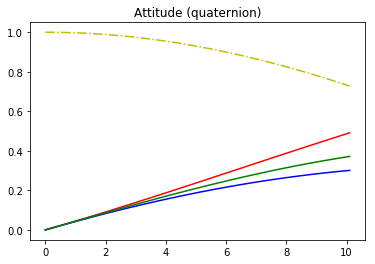

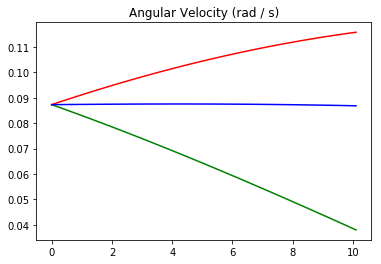

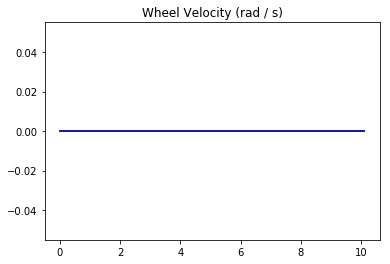

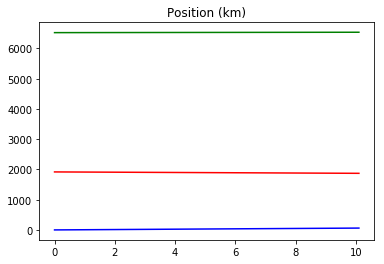

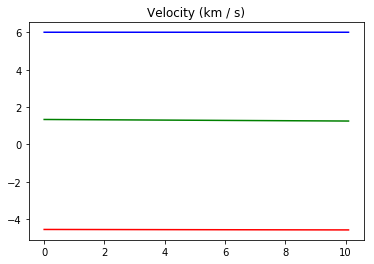

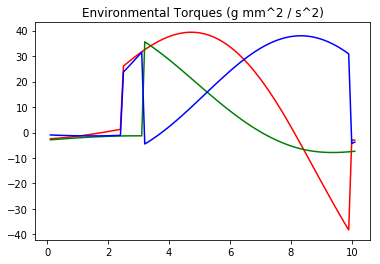

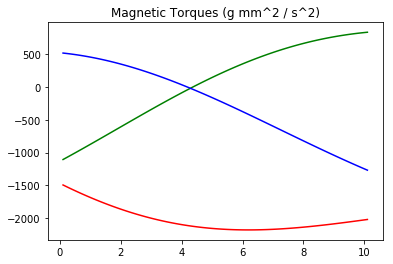

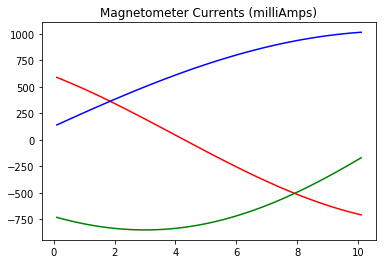

In [5]:
if __name__ == '__main__' and not '__file__' in globals():
    x, v, q, w, whl, t, env, cur, mags = master(10)#(60*60*4)
    print_results(x, v, q, w, whl, t, env, cur, mags)